In [1]:
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, CSVLogger
from models import ResearchModels
from data import DataSet
import time

Using TensorFlow backend.


In [14]:
batch_size = 5 #32 for LSTM; 8 for CRNN; 5 for CNN-3d

model = 'conv_3d'  # see `models.py` for more
saved_model = None  # None or weights file
class_limit = None  # int, can be 1-101 or None
seq_length = 90
load_to_memory = True  # pre-load the sequences into memory

# Chose images or features and image shape based on network.
if model == 'conv_3d' or model == 'crnn' or model == 'c3d':
    data_type = 'images'
    #image_shape = (80, 80, 3)
    image_shape = (144, 81, 3) # Work for crnn with batch size 8
    #image_shape = (112, 63, 3) # Work for 3dcnn with batch size 5
    load_to_memory = False
elif model == 'lrcn':
    data_type = 'images'
    image_shape = (144, 81, 3)
else:
    data_type = 'features'
    image_shape = None

# MLP requires flattened features.
if model == 'mlp':
    concat = True
else:
    concat = False

In [ ]:
%env CUDA_VISIBLE_DEVICES=1
data = DataSet(seq_length=seq_length,class_limit=class_limit)
#X, y = data.get_all_sequences_in_memory(batch_size, 'train', data_type, concat)
X_test, y_test = data.get_all_sequences_in_memory('test', data_type, concat)
rm = ResearchModels(len(data.classes), model, seq_length, saved_model)

rm.model.load_weights("data/checkpoints/conv_3d-images.010-0.154.hdf5")
print("Created model and loaded weights from file")

env: CUDA_VISIBLE_DEVICES=1
Loading 534 samples into memory for testing.


In [5]:
scores = rm.model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (rm.model.metrics_names[1], scores[1]*100))

acc: 90.26%


In [6]:
from sklearn.metrics import classification_report, confusion_matrix
y_pred = rm.model.predict_classes(X_test)
print(y_pred)

534/534 [==============================] - 3s     
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 1 2 2 2 2 2 2 1 1 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 2 2 1 2 2 2 1 2 2 2 1 2 2 2 2 2 1 1 2 2
 1 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 1 1 2 2 2 2 2 2 2 2 2 2 2 1 2 1 2 2 2 2
 2 1 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 5 4 4 5 5 4 5 5 4 4 4 4 5 5 5 4 5 4 5 4 5 4
 5 5 5 4 4 5 5 4 4 4 4 5 4 5 4 5 4 4 4 5 4 4 5 4 5 4 5 4 5 5 5 4 5 5 5 5 4
 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 

In [9]:
import numpy as np
print(np.argmax(y_test,axis=1))

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 

In [10]:
y_true = ['1', '2', '3', '4', '5', '6']
print(confusion_matrix(np.argmax(y_test,axis=1), y_pred))

[[ 89   0   0   0   0   0]
 [  0  58   1   0   0   0]
 [  0  18 101   0   0   0]
 [  0   0   0 118   0   0]
 [  0   0   0   0  30  30]
 [  0   0   0   2   1  86]]


Automatically created module for IPython interactive environment
Confusion matrix, without normalization
[[ 89   0   0   0   0   0]
 [  0  58   1   0   0   0]
 [  0  18 101   0   0   0]
 [  0   0   0 118   0   0]
 [  0   0   0   0  30  30]
 [  0   0   0   2   1  86]]
Normalized confusion matrix
[[ 1.    0.    0.    0.    0.    0.  ]
 [ 0.    0.98  0.02  0.    0.    0.  ]
 [ 0.    0.15  0.85  0.    0.    0.  ]
 [ 0.    0.    0.    1.    0.    0.  ]
 [ 0.    0.    0.    0.    0.5   0.5 ]
 [ 0.    0.    0.    0.02  0.01  0.97]]


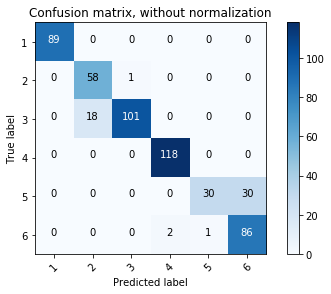

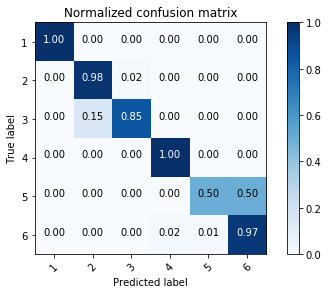

In [11]:
# %matplotlib inline
print(__doc__)

import itertools
import numpy as np
import matplotlib.pyplot as plt

# from sklearn import svm, datasets
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import confusion_matrix

# import some data to play with
# iris = datasets.load_iris()
# X = iris.data
# y = iris.target
# class_names = iris.target_names
class_names = ['1', '2', '3', '4', '5', '6']
# class_names = ['1', '2', '3', '4']
# 
# # Split the data into a training set and a test set
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
# 
# # Run classifier, using a model that is too regularized (C too low) to see
# # the impact on the results
# classifier = svm.SVC(kernel='linear', C=0.01)
# y_pred = classifier.fit(X_train, y_train).predict(X_test)


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(np.argmax(y_test,axis=1), y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
fig1 = plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
fig2 = plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [13]:
#fig2.savefig('./cm_lstm.png') # Use fig. here
fig2.savefig('./cm_lstm.png', dpi=1000, bbox_inches='tight') # Better quality and no cropped title